# Structured hierarchical linear models

This project proposes a family of models, the *structured hierarchical linear model*, in order to incorporate biological prior knowledge into probabilistic models. The models can be easily described as:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\mathbf{y} \mid \boldsymbol \gamma & \sim \text{HM}(\mathbf{y} \mid \gamma)\\
\end{align}

The MRF is encoded as Potts-model. The HM can either be linear (this notebook) or nonlinear ([this notebook](./01b-hierarchical_nonlinear_model.ipynb)).

## SHMs for inferring pan-cellline essential genes

We apply our model to infer essential pan-cellline genes from CRISPR genes:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\tau^2_c & \sim \text{Inverse-Gamma}(2, 1) \\
\beta_{gc} \mid \gamma_g & \sim \mathcal{N}(\gamma_g, \tau_c^2) \\
l_{s} & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Half-Cauchy}(0, 3)\\
x_{gcs} \mid \beta_{cg}, l_s & \sim \mathcal{N}\left(l_{s} + o_s \cdot \beta_{cg}, \sigma^2 \right) \\
\end{align}

where we use $l_s$ as sgRNA correction factor and $o_s$ to model its binding affinity. Noise is expected to me homoscedastic. We compare the model against a model that does not have the clustering in the latent space and one that has a classical clustering model on the latent space.

In [1]:
import shm
import numpy
import networkx
import matplotlib
import seaborn as sns
import pandas as pd
import pickle
import pymc3 as pm

In [2]:
import arviz as az
import shm.plot as sp
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import os

In [4]:
from pymc3 import model_to_graphviz

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 3)

Populating the interactive namespace from numpy and matplotlib


In [6]:
sns.set_style(
  "white",
  {
      "xtick.bottom": True,
      "ytick.left": True,
      "axes.spines.top": False,
      "axes.spines.right": False,
  },
)

In [56]:
def read_pickle(infile):
    with open(infile, "rb") as fh:
        d = pickle.load(fh)
    return d

In [51]:
suffix = "0_modified_grnas-noise_sd_1"

# Model evaluation

In [52]:
readout_file = "../data_raw/simulated-large-{}-simulated_data.tsv".format(suffix)
graph_file = "../data_raw/simulated-large-{}-graph.pickle".format(suffix)
data_file = "../data_raw/simulated-large-{}-data.pickle".format(suffix)

In [57]:
G = read_pickle(graph_file)
data = read_pickle(data_file)

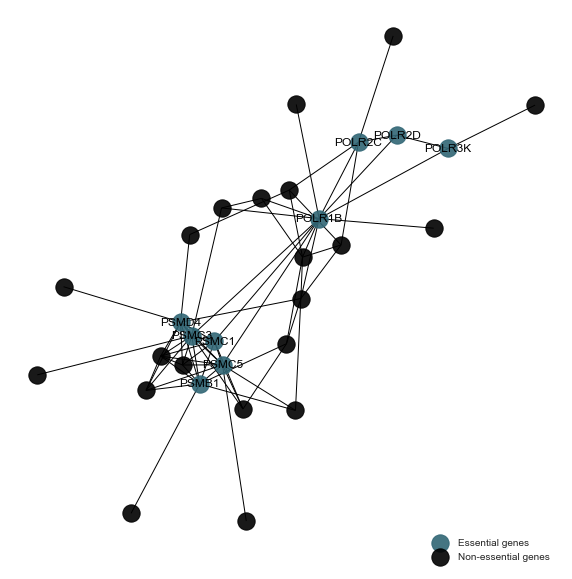

In [58]:
plt.figure(figsize=(10, 10))
pos = networkx.spring_layout(G)
networkx.draw_networkx_nodes(
  G, pos=pos,
  nodelist=list(data['essential_genes']), node_size=300,
  node_color='#316675', font_size=15, alpha=.9, label="Essential genes")
networkx.draw_networkx_nodes(
  G, pos=pos,
  nodelist=list(data['nonessential_genes']), node_size=300,
  node_color='black', font_size=15, alpha=.9, label="Non-essential genes")
networkx.draw_networkx_edges(G, pos=pos)
networkx.draw_networkx_labels(G, pos=pos, 
                              labels={e: e for e in list(data['essential_genes'])})
plt.axis('off')
plt.legend(loc='center right', fancybox=False, framealpha=0, shadow=False,
           borderpad=1, bbox_to_anchor=(1, 0), ncol=1)
plt.show()

In [62]:
np.repeat([0, 1, 2], 2)

array([0, 0, 1, 1, 2, 2])

In [61]:
np.tile(np.repeat([0, 1, 2], 2), 2)

array([0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2])

## Clustering model

In [21]:
trace_dir = "../../../results/clustering_model-{}_trace".format(suffix)
with SHLM(readout, model="clustering") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model
Building two-state model


IndexError: list index out of range

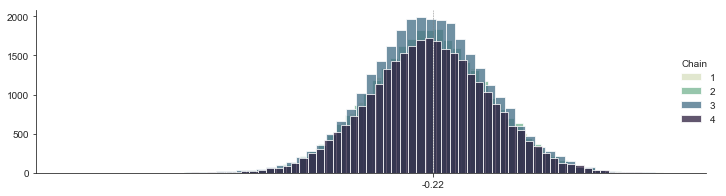

In [14]:
sp.plot_hist(trace, "gamma", 14, "");

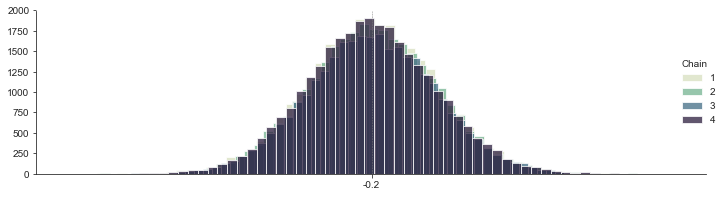

In [15]:
sp.plot_hist(trace, "gamma", 18, "");

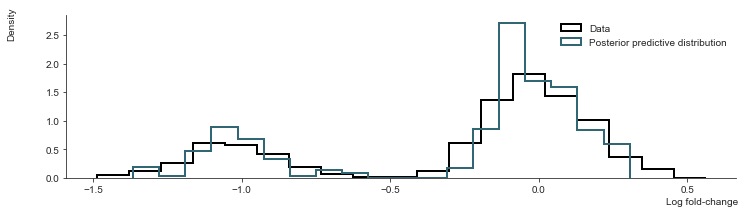

In [16]:
sp.plot_steps(readout, ppc_trace, bins=19);

In [17]:
data['gamma'][[0, 4]]

array([-0.83756546, -0.91345924])

In [18]:
numpy.mean(trace['gamma'], 0)[[14, 18]]

array([-0.22476012, -0.20000103])

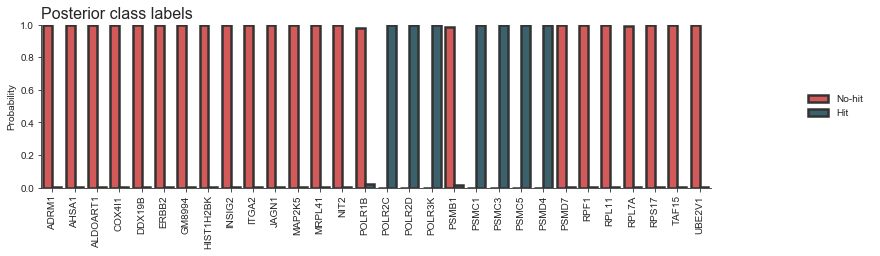

In [19]:
sp.plot_posterior_labels(
    trace, 
    [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


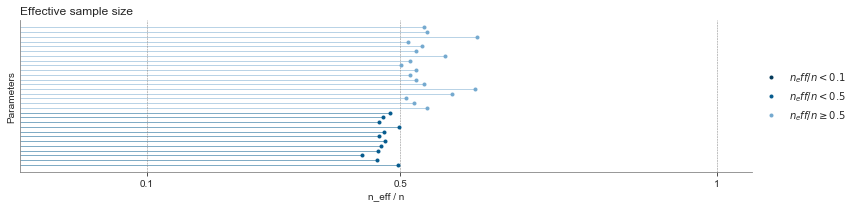

In [20]:
sp.plot_neff(trace, "gamma");

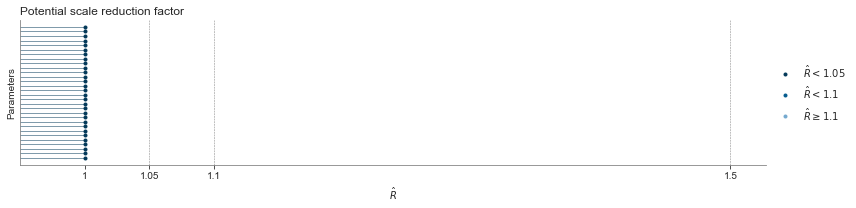

In [21]:
sp.plot_rhat(trace, "gamma");

In [22]:
np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]

array([-0.22476012, -1.04037682, -1.04499489, -1.08365068, -0.20000103,
       -1.16229813, -0.94430302, -1.04415101, -1.04576918, -0.07595068,
        0.1656425 , -0.1338413 ,  0.00285513, -0.06002738,  0.17935712,
       -0.11787071, -0.06150235, -0.054164  ,  0.02634038, -0.00623241,
       -0.10677596,  0.06941595,  0.0472081 ,  0.1431643 ,  0.11791911,
       -0.0498032 ,  0.01404989, -0.12028241, -0.02385673,  0.0596966 ])

In [23]:
np.mean((data["gamma"] - np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())])**2)

0.03161725860300341

## MRF model

In [99]:
trace_dir = "../../../results/test_tern_0_trace"
with SHLM(readout, model="clustering", graph=G) as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    #prior = pm.sample_prior_predictive(10000)
    #ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model
Building two-state model


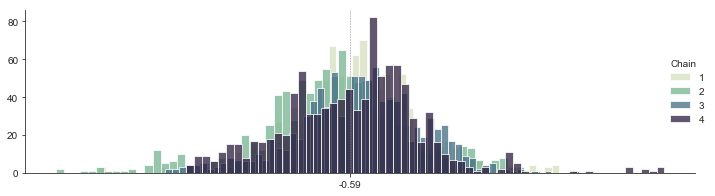

In [100]:
sp.plot_hist(trace, "gamma", 0, "");

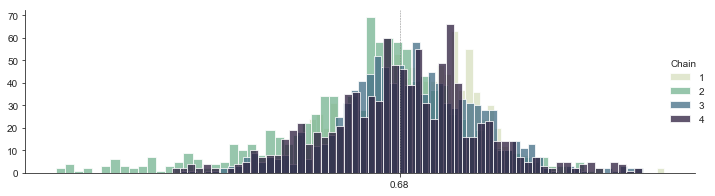

In [101]:
sp.plot_hist(trace, "gamma", 1, "");

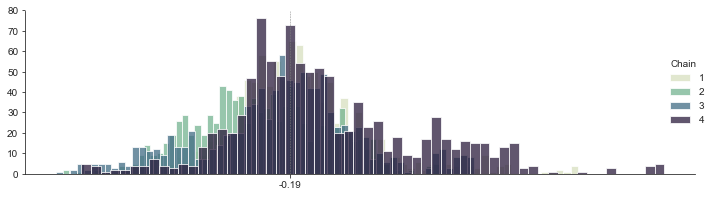

In [103]:
sp.plot_hist(trace, "gamma", 2, "");

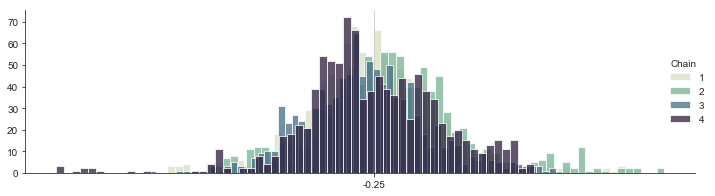

In [104]:
sp.plot_hist(trace, "beta", 0, "");

In [105]:
data['gamma']

array([-0.59391366,  0.8470609 , -0.13204294])

In [106]:
data['beta']

array([-0.26824216,  0.21635191, -0.57538467,  0.43620294, -0.19030173,
        0.07975977])

(array([1885.,    0.,    0.,    0.,    0., 1606.,    0.,    0.,    0.,
         509.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

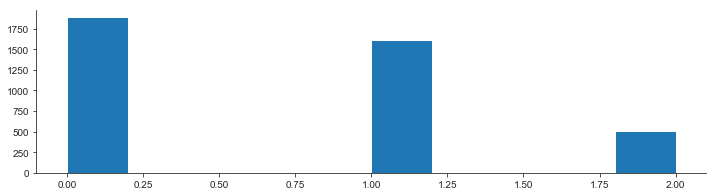

In [107]:
plt.hist(trace['z'][:,0])

(array([ 463.,    0.,    0.,    0.,    0., 1565.,    0.,    0.,    0.,
        1972.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

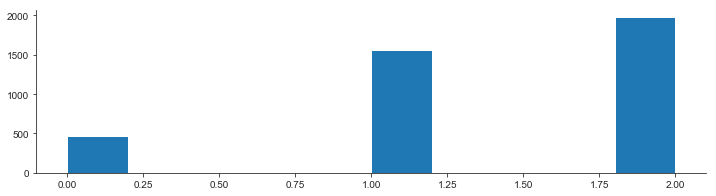

In [108]:
plt.hist(trace['z'][:,1])

(array([1259.,    0.,    0.,    0.,    0., 1853.,    0.,    0.,    0.,
         888.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

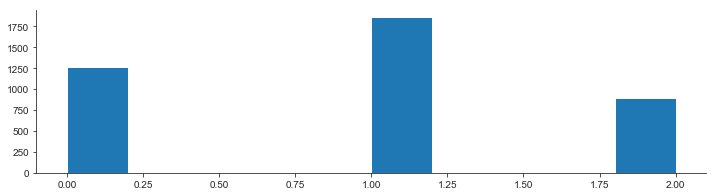

In [109]:
plt.hist(trace['z'][:,2])

In [76]:
numpy.mean(trace['z'], 0)

array([0.8055 , 1.2235 , 0.91525])

In [52]:
numpy.mean(trace['beta'], 0)

array([-0.05818838, -0.108238  ,  0.27808383, -0.02994802])

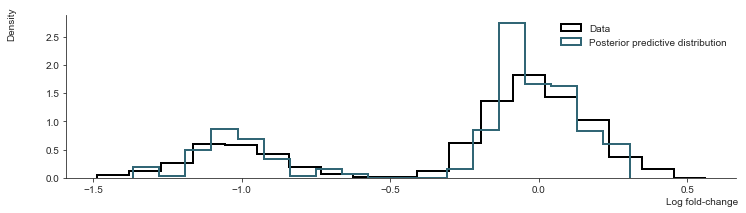

In [29]:
sp.plot_steps(readout, ppc_trace, bins=19);

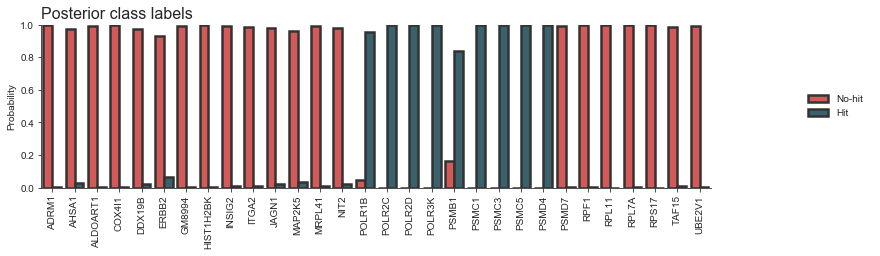

In [30]:
sp.plot_posterior_labels(
    trace,  [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


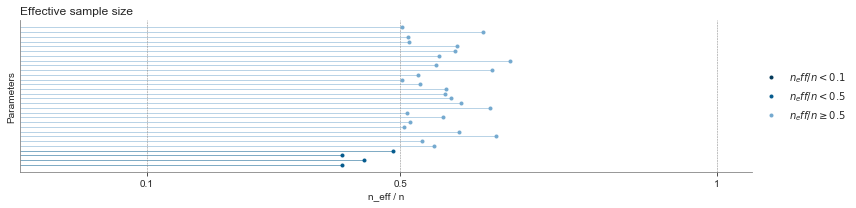

In [31]:
sp.plot_neff(trace, "gamma");

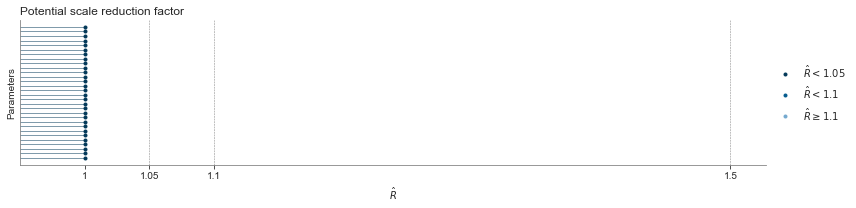

In [32]:
sp.plot_rhat(trace, "gamma");

In [33]:
np.mean((data["gamma"] - np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())])**2)

0.024646579518776388

## Model blub


In [8]:
readout_file = "../data_raw/biological_ternary-data.tsv"
graph_file = "../data_raw/biological_ternary-graph.pickle"

In [9]:
readout = pd.read_csv(readout_file, sep="\t")
G = read_graph(graph_file)

In [10]:
readout.shape

(27856, 8)

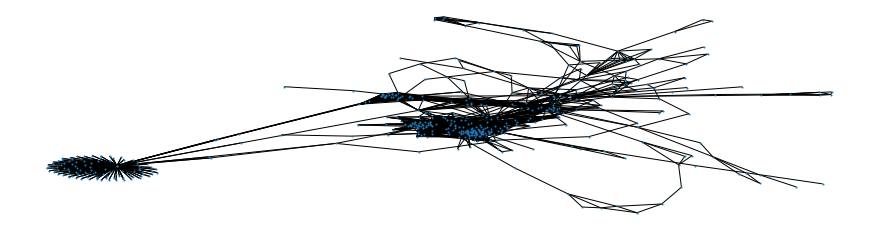

In [11]:
networkx.draw(G, node_size=1)

In [12]:
trace_dir = "../../../results/biological_ternary/biological_ternary-mrf_model_trace"
with CopynumberSHLM(readout, model="mrf", graph=G, use_affinity=True, n_states=3) as model:
    trace = pm.load_trace(trace_dir, model = model.model)
#    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building mrf hierarchical model
Using categorical MRF with three states
Building three-state model


In [77]:
trace_dir = "../../../results/biological_ternary/biological_ternary-clustering_model_trace"
with CopynumberSHLM(readout, model="clustering", graph=G, use_affinity=True, n_states=3) as model:
    c_trace = pm.load_trace(trace_dir, model = model.model)
#    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model
Using 3 cluster centers
Building three-state model


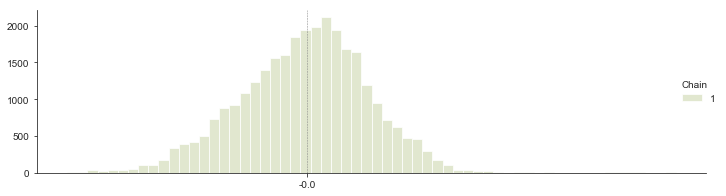

In [19]:
sp.plot_hist(trace, "gamma", 2, "");

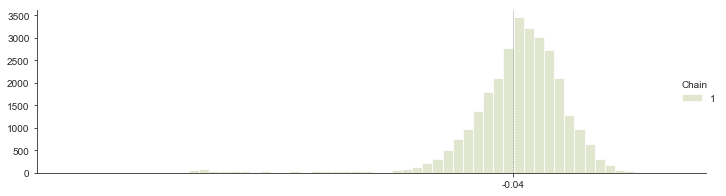

In [23]:
sp.plot_hist(trace, "gamma", 1, "");

In [24]:
model._index_to_gene.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

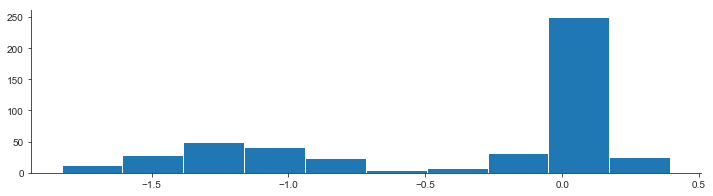

In [22]:
plt.hist(np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]);

In [28]:
trace['z']

array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [2, 2, 1, ..., 0, 1, 1],
       ...,
       [2, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 2],
       [2, 0, 1, ..., 0, 1, 1]])

In [53]:
np.setdiff1d([0, 1, 2], 0)

array([1, 2])

In [135]:
def f(x):
    s = pd.Series(x).value_counts()
    s /= np.sum(s)
    keys = list(map(str, s.keys()))
    d = {e: i for e, i in zip(keys, s)}
    for k in np.setdiff1d(np.array(['0', '1', '2']), keys):
        d[k] = 0.0
    return np.array([d[k] for k in sorted(d.keys())])
f(trace['z'][:,42])

array([1., 0., 0.])

In [136]:
s = np.apply_along_axis(lambda x: f(x), 0, trace['z']);

In [137]:
ss = s.T

In [144]:
ss = ss[:5,:]

In [146]:
np.sum(ss, axis=1)

array([1., 1., 1., 1., 1.])

In [157]:
trace['z']

array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [2, 2, 1, ..., 0, 1, 1],
       ...,
       [2, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 2],
       [2, 0, 1, ..., 0, 1, 1]])

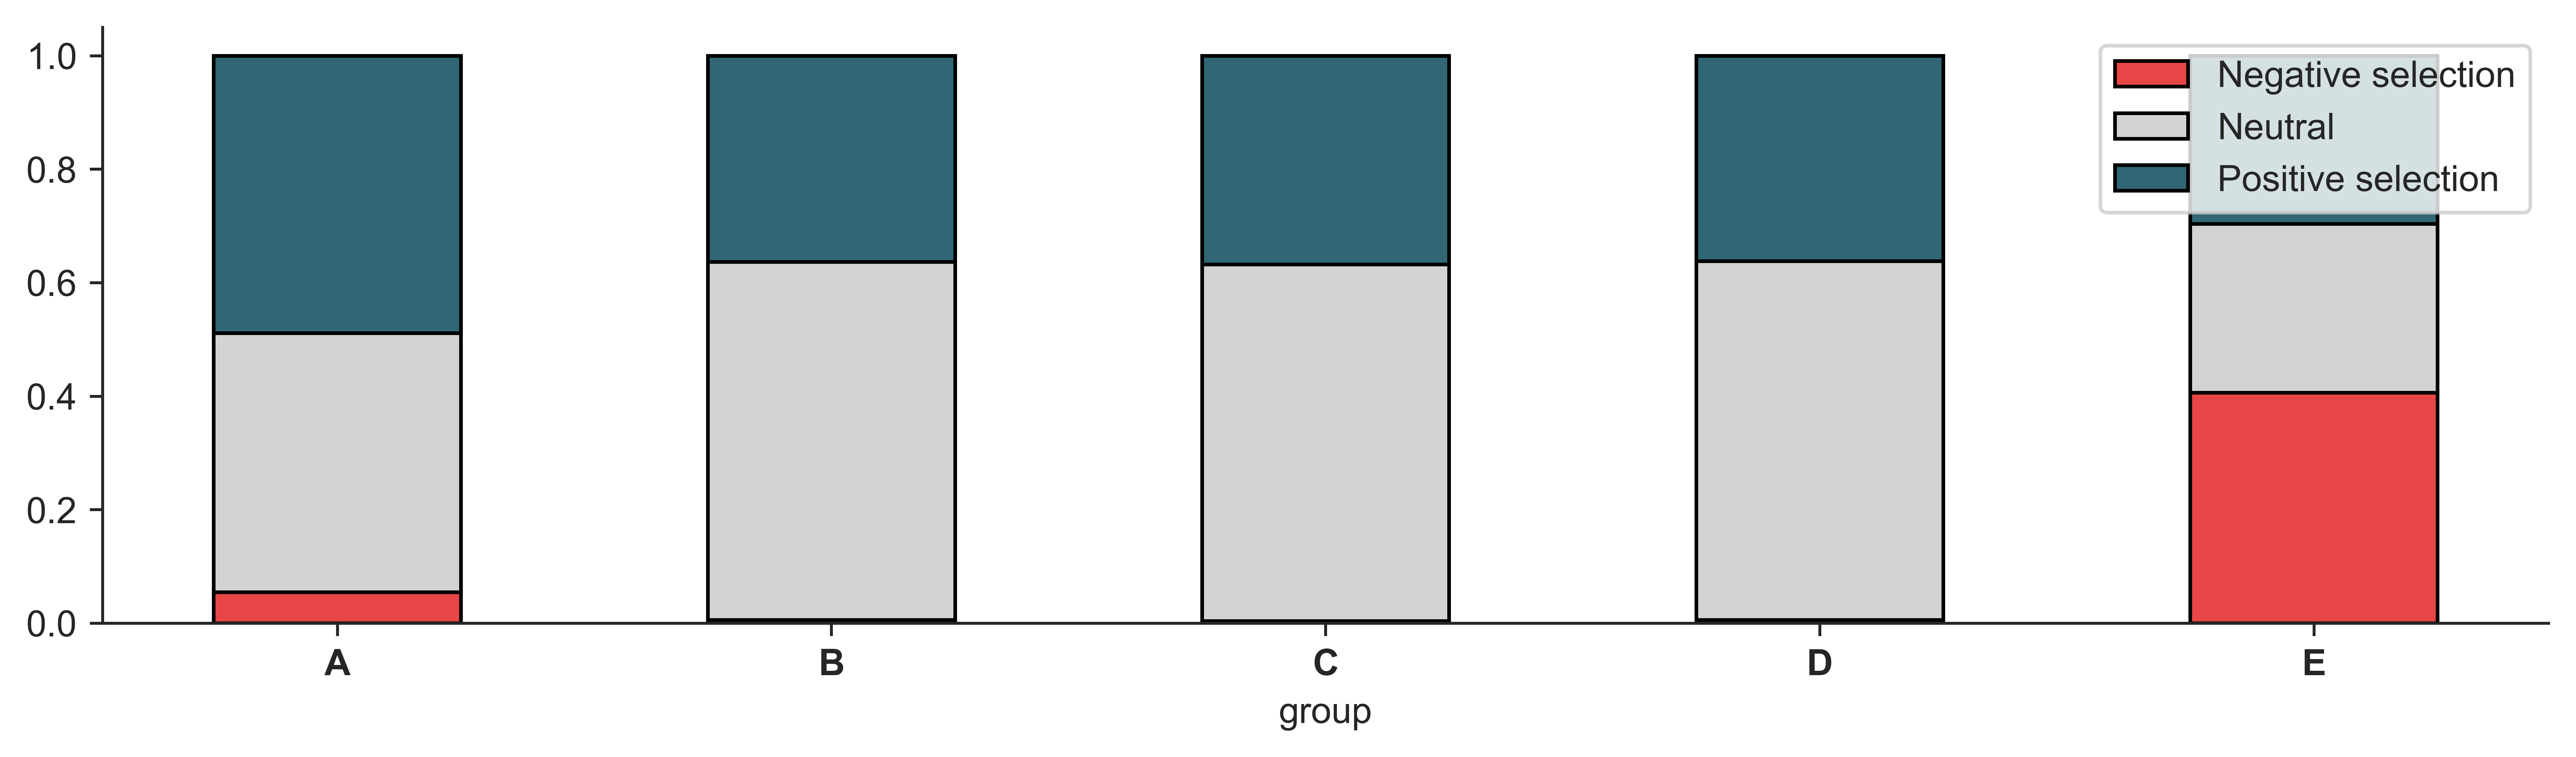

In [161]:

bars = np.add(ss[:,0], ss[:,1]).tolist()
r = arange(ss.shape[0])
names = ['A','B','C','D','E']
barWidth = .5
fig, ax = plt.subplots(dpi=720)

# Create brown bars
ax.bar(r, ss[:,0], color='#E84646', edgecolor='black', width=barWidth, label="Negative selection")
# Create green bars (middle), on top of the firs ones
ax.bar(r, ss[:,1], bottom=ss[:,0], color='lightgrey', edgecolor='black', width=barWidth, label="Neutral")
# Create green bars (top)
ax.bar(r, ss[:,2], bottom=bars, color='#316675', edgecolor='black', width=barWidth, label="Positive selection")
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
plt.legend()
sns.despine()
plt.show()

In [119]:
def compute_posterior_probabilities(trace):
    def f(x):
        s = pd.Series(x).value_counts()
        s /= np.sum(s)
        keys = list(map(str, s.keys()))
        d = {e: i for e, i in zip(keys, s)}
        for k in np.setdiff1d(np.array(['0', '1', '2']), keys):
            d[k] = 0.0
        return np.array([d[k] for k in sorted(d.keys())])

    probs = np.apply_along_axis(lambda x: f(x), 0, trace['z']).T
    return probs

In [120]:
probs = compute_posterior_probabilities(c_trace)

In [96]:
df = pd.DataFrame(
      data=probs,
      columns=["dependency_factor", "neutral", "restriction_factor"])
df["gene"] = [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]
df["is_essential"] = df.dependency_factor + df.restriction_factor 
df["predicted"] = np.where(df["is_essential"].values <= 0.25, 0, 1)

In [118]:
df

,dependency_factor,neutral,restriction_factor,gene,is_essential,predicted,truth
0,0.494183,0.005817,0.500000,ABCG8,0.994183,1,0
1,0.495083,0.005050,0.499867,ADAM2,0.994950,1,0
2,0.493933,0.006083,0.499983,ADAM20,0.993917,1,0
3,0.494467,0.005533,0.500000,ADAM30,0.994467,1,0
4,0.495000,0.005083,0.499917,AICDA,0.994917,1,0
5,0.494333,0.005667,0.500000,AIPL1,0.994333,1,0
6,0.703800,0.296200,0.000000,ALYREF,0.703800,1,1
7,0.493900,0.006100,0.500000,APOA4,0.993900,1,0
8,0.741267,0.258733,0.000000,AQR,0.741267,1,1
9,0.758967,0.241033,0.000000,ARCN1,0.758967,1,1


In [97]:
essentials = pd.read_csv("../../../data_raw/achilles/achilles-common_essentials.csv", sep=" ")
nonessentials = pd.read_csv("../../../data_raw/achilles/achilles-common_nonessentials.csv", sep=" ")

In [148]:
df["truth"] = -1
df.loc[df["gene"].isin(essentials["gene"]), "truth"] = 1
df.loc[df["gene"].isin(nonessentials["gene"]), "truth"] = 0
df = df[df.truth != -1]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [113]:
def print_confusion_matrix(confusion_matrix, class_names,  fontsize=14):   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [116]:
df.truth.values

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [117]:
df.predicted.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

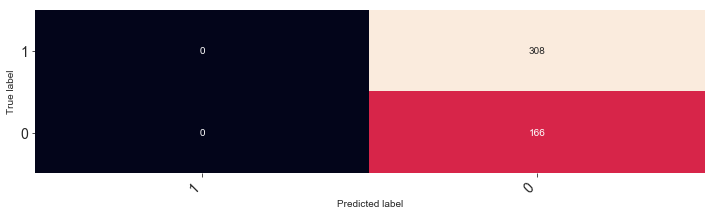

In [115]:
cm = confusion_matrix(df.truth.values, df.predicted.values)
s = print_confusion_matrix(cm, ["1", "0"])

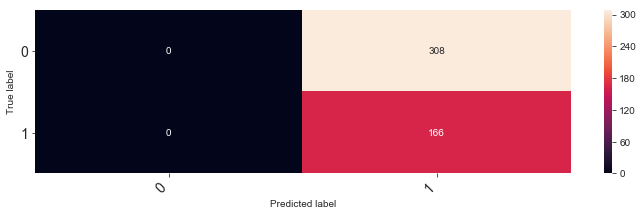

In [88]:
cm = confusion_matrix(df.truth.values, df.predicted.values)
s = print_confusion_matrix(cm, ["0", "1"])

In [124]:
from sklearn.metrics import roc_curve, auc

In [143]:
fpr, tpr, _ = roc_curve(df.truth.values, df.is_essential.values)
roc_auc = auc(fpr, tpr)

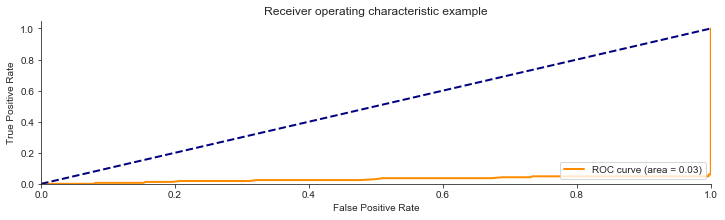

In [144]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()